In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
from src.osrm import run_osrm_in_chunks


In [2]:
df1 = pd.read_parquet("../data/original/yellow_tripdata_2009-01.parquet",
                       columns=['Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', 'Trip_Distance'])

In [3]:
df = pd.read_parquet("data/osrm/osrm_results.parquet")

In [4]:
# Convertir a datetime
df1['Trip_Pickup_DateTime'] = pd.to_datetime(df1['Trip_Pickup_DateTime'])
df1['Trip_Dropoff_DateTime'] = pd.to_datetime(df1['Trip_Dropoff_DateTime'])

# Calcular duración en segundos
df1['Real_time'] = (df1['Trip_Dropoff_DateTime'] - df1['Trip_Pickup_DateTime']).dt.total_seconds()
df1['Trip_Distance_m'] = df1['Trip_Distance'] * 1609.34

df['Real_time']=df1['Real_time']
df['Real_distance']=df1['Trip_Distance_m'] 
df1 = None

In [5]:
# Error de distancia (en metros y %)
df['dist_diff_m'] = df['route_distance_m'] - df['Real_distance']
df['dist_pct_error'] = (df['dist_diff_m'] / df['Real_distance']) * 100

# Error de tiempo (en segundos y %)
df['time_diff_s'] = df['route_duration_s'] - df['Real_time']
df['time_pct_error'] = (df['time_diff_s'] / df['Real_time']) * 100


In [6]:
df[['dist_diff_m', 'time_diff_s']].describe()

,dist_diff_m,time_diff_s
count,1.409180e+07,1.409180e+07
mean,4.699914e+00,-2.702324e+02
std,4.869669e+03,2.503937e+03
min,-8.026657e+04,-3.633288e+06
25%,-1.264146e+02,-3.303000e+02
50%,2.449000e+01,-1.628000e+02
75%,2.135200e+02,-4.640000e+01
max,8.983994e+05,9.751260e+04


In [7]:
df

,Trip_Pickup_DateTime,Passenger_Count,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt,pickup_hour_sin,pickup_hour_cos,...,haversine_distance_m,idx,route_distance_m,route_duration_s,Real_time,Real_distance,dist_diff_m,dist_pct_error,time_diff_s,time_pct_error
0,2009-01-04 02:52:00,1,-73.991957,40.721567,-73.993803,40.695922,8.9,9.40,0.500000,0.866025,...,2855.835897,0,4058.1,461.3,600.0,4232.5642,-174.4642,-4.121950,-138.7,-23.116667
1,2009-01-04 03:31:00,3,-73.982102,40.736290,-73.955850,40.768030,12.1,14.60,0.707107,0.707107,...,4164.867307,1,5113.6,479.9,420.0,7322.4970,-2208.8970,-30.165898,59.9,14.261905
2,2009-01-03 15:43:00,5,-74.002587,40.739748,-73.869983,40.770225,23.7,28.44,-0.707107,-0.707107,...,11672.167416,2,16624.6,1364.3,840.0,16656.6690,-32.0690,-0.192529,524.3,62.416667
3,2009-01-01 20:52:58,1,-73.974267,40.790955,-73.996558,40.731849,14.9,18.45,-0.866025,0.500000,...,6835.176748,3,8032.7,921.1,1262.0,8046.7000,-14.0000,-0.173984,-340.9,-27.012678
4,2009-01-24 16:18:23,1,-74.001580,40.719382,-74.008378,40.720350,3.7,3.70,-0.866025,-0.500000,...,582.928793,4,969.1,162.3,393.0,643.7360,325.3640,50.543080,-230.7,-58.702290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092408,2009-01-27 14:36:00,5,-73.982013,40.743330,-73.994328,40.750130,6.5,6.50,-0.500000,-0.866025,...,1283.742913,92408,1439.0,190.9,600.0,1432.3126,6.6874,0.466895,-409.1,-68.183333
14092409,2009-01-27 13:56:00,1,-73.972788,40.761988,-73.951477,40.778217,8.1,10.00,-0.258819,-0.965926,...,2545.044336,92409,3373.7,408.3,360.0,3122.1196,251.5804,8.058000,48.3,13.416667
14092410,2009-01-23 08:39:44,1,-73.977467,40.751861,-74.009913,40.713470,14.5,14.50,0.866025,-0.500000,...,5069.266708,92410,5755.7,831.2,1351.0,6115.4920,-359.7920,-5.883288,-519.8,-38.475204
14092411,2009-01-24 23:05:00,3,-73.981295,40.753000,-73.949453,40.779520,10.9,11.40,-0.258819,0.965926,...,3985.861506,92411,5577.3,559.9,600.0,6195.9590,-618.6590,-9.984879,-40.1,-6.683333


In [8]:
df['Trip_Pickup_DateTime'].describe()

count                         14092413
mean     2009-01-17 07:21:06.557401600
min                2009-01-01 00:00:00
25%                2009-01-09 19:21:41
50%                2009-01-17 09:06:00
75%                2009-01-24 20:26:56
max                2009-01-31 23:59:59
Name: Trip_Pickup_DateTime, dtype: object

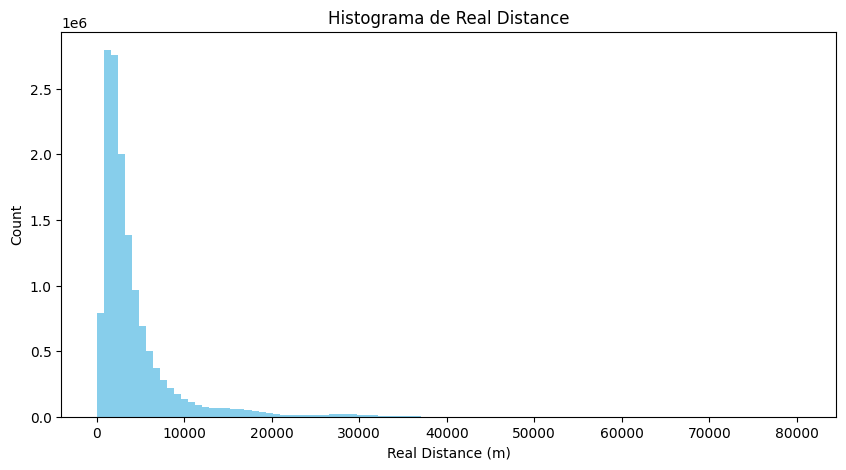

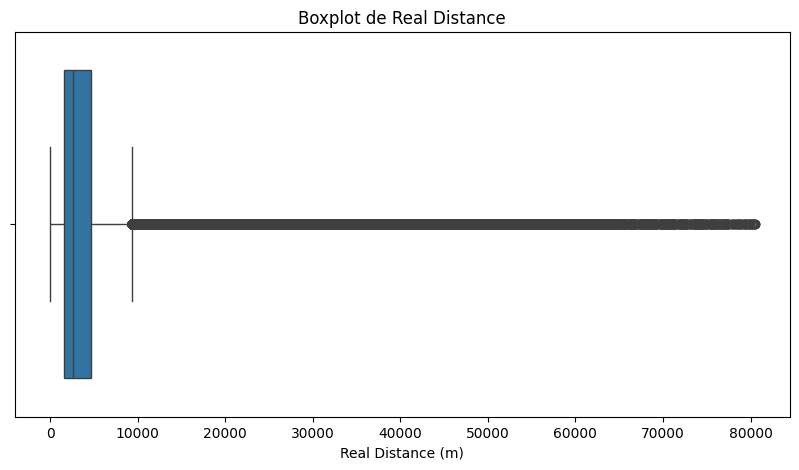

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma
plt.figure(figsize=(10,5))
plt.hist(df['Real_distance'], bins=100, color='skyblue')
plt.xlabel('Real Distance (m)')
plt.ylabel('Count')
plt.title('Histograma de Real Distance')
plt.show()

# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Real_distance'])
plt.xlabel('Real Distance (m)')
plt.title('Boxplot de Real Distance')
plt.show()

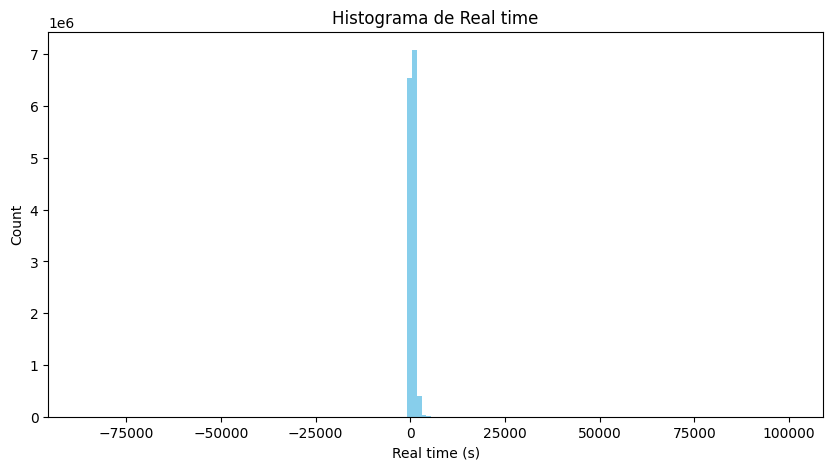

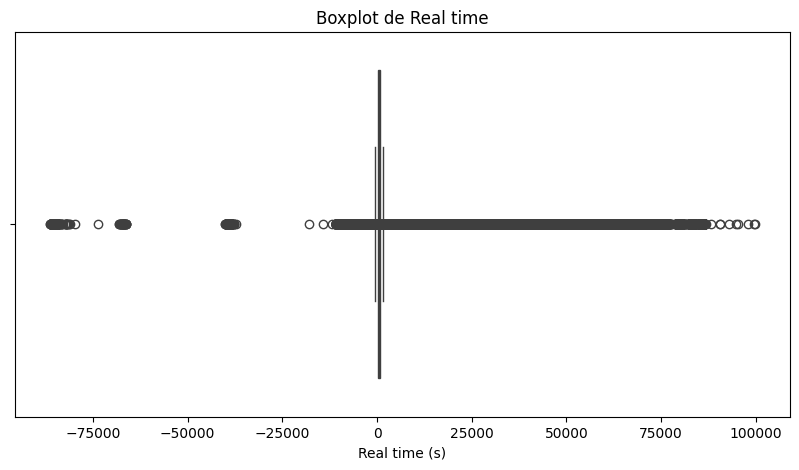

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma
plt.figure(figsize=(10,5))
plt.hist(df[df['Real_time'] <= 100000]['Real_time'], bins=150, color='skyblue')
plt.xlabel('Real time (s)')
plt.ylabel('Count')
plt.title('Histograma de Real time')
plt.show()

# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x=df[df['Real_time'] <= 100000]['Real_time'])
plt.xlabel('Real time (s)')
plt.title('Boxplot de Real time')
plt.show()